In [1]:
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

#check tensorflow version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use Tensorflow version 1.0 or newer. You are using ()'
print('TensorFlow Version : {}'.format(tf.__version__))

#check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please ensure you have installed TensorFlow correctly.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version : 2.0.0


C:\Users\juyee\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: No GPU found. Please ensure you have installed TensorFlow correctly.
  # This is added back by InteractiveShellApp.init_path()


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression

from collections import Counter
import nltk
import seaborn as sns
import string
from nltk.corpus import stopwords
# import re
# from autocorrect import spell

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.models import Sequential
from keras.layers import Dense
from keras.backend import eval
from keras.optimizers import Adam
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D,MaxPooling1D
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os

Using TensorFlow backend.


In [3]:
import regex as re

In [4]:
data= pd.read_json('Home_and_Kitchen_5.json',lines=True)
data.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,APYOBQE6M18AA,0615391206,Martin Schwartz,"[0, 0]",My daughter wanted this book and the price on ...,5,Best Price,1382140800,"10 19, 2013"
1,A1JVQTAGHYOL7F,0615391206,Michelle Dinh,"[0, 0]",I bought this zoku quick pop for my daughterr ...,5,zoku,1403049600,"06 18, 2014"
2,A3UPYGJKZ0XTU4,0615391206,mirasreviews,"[26, 27]",There is no shortage of pop recipes available ...,4,"Excels at Sweet Dessert Pops, but Falls Short ...",1367712000,"05 5, 2013"
3,A2MHCTX43MIMDZ,0615391206,"M. Johnson ""Tea Lover""","[14, 18]",This book is a must have if you get a Zoku (wh...,5,Creative Combos,1312416000,"08 4, 2011"
4,AHAI85T5C2DH3,0615391206,PugLover,"[0, 0]",This cookbook is great. I have really enjoyed...,4,A must own if you own the Zoku maker...,1402099200,"06 7, 2014"


In [5]:
review=pd.DataFrame(data.groupby('overall').size().sort_values(ascending=False).rename('No of Users').reset_index())
review.head()

,overall,No of Users
0,5,349696
1,4,105508
2,3,45059
3,1,27106
4,2,24313


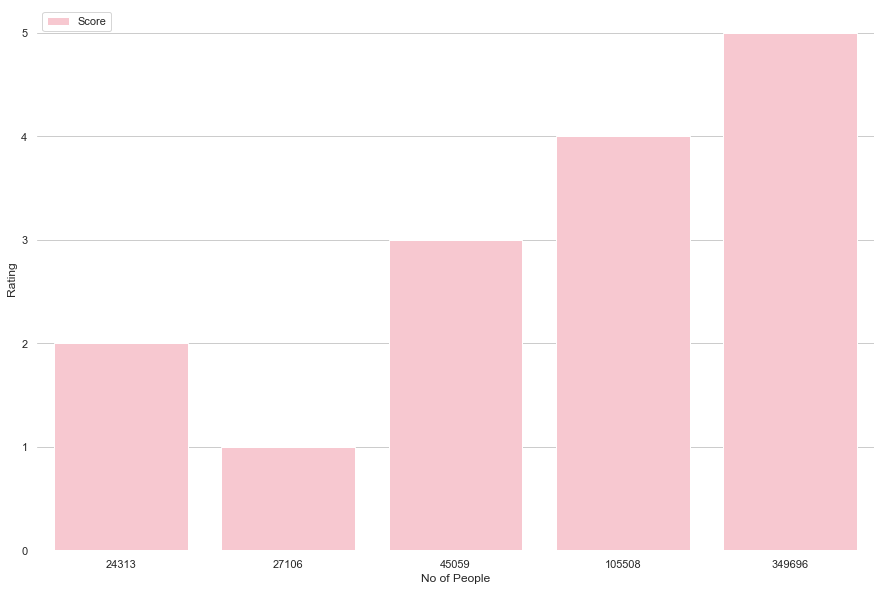

In [5]:
import seaborn as sns 
import matplotlib.pyplot as plt 
sns.set(style="whitegrid")

f, ax = plt.subplots(figsize=(15, 10)) 
sns.set_color_codes("pastel") 
sns.barplot(y="overall", x="No of Users", data=review.iloc[:20, :10],label="Score", color="pink")

ax.legend(ncol=2, loc="upper left", frameon=True) 
ax.set(xlabel="No of People",ylabel="Rating") 
sns.despine(left=True, bottom=True) 
plt.show()

In [7]:
permanent = data[['overall' , 'reviewText' , 'summary' , 'reviewerName']]
mpermanent=permanent.dropna()
mpermanent.head()

,overall,reviewText,summary,reviewerName
0,5,My daughter wanted this book and the price on ...,Best Price,Martin Schwartz
1,5,I bought this zoku quick pop for my daughterr ...,zoku,Michelle Dinh
2,4,There is no shortage of pop recipes available ...,"Excels at Sweet Dessert Pops, but Falls Short ...",mirasreviews
3,5,This book is a must have if you get a Zoku (wh...,Creative Combos,"M. Johnson ""Tea Lover"""
4,4,This cookbook is great. I have really enjoyed...,A must own if you own the Zoku maker...,PugLover


In [8]:
check =  mpermanent[mpermanent["reviewText"].isnull()]
check.head()

,overall,reviewText,summary,reviewerName


In [12]:
actualrating = mpermanent[(mpermanent['overall'] == 1) | (mpermanent['overall'] == 5)]
actualrating.shape

(373457, 4)

In [13]:
y = actualrating['overall'].reset_index()
x = actualrating['reviewText'].reset_index()

In [14]:
len(y)

373457

In [15]:
y

,index,overall
0,0,5
1,1,5
2,3,5
3,5,5
4,6,5
...,...,...
373452,551677,5
373453,551678,5
373454,551679,5
373455,551680,5


In [16]:
x

,index,reviewText
0,0,My daughter wanted this book and the price on ...
1,1,I bought this zoku quick pop for my daughterr ...
2,3,This book is a must have if you get a Zoku (wh...
3,5,If you have a Zoku Quick Pop maker (or two.......
4,6,This book is so beautifully illustrated and ea...
...,...,...
373452,551677,These ice pop molds are awesome! Bright kid-ha...
373453,551678,great popsicle molds - very nice quality - and...
373454,551679,My kids and I are loving these - putting our c...
373455,551680,"I love these ice pop makers. First off, I love..."


In [28]:
prodreviews = pd.merge(x,y)
#del prodreviews['index']
prodreviews = prodreviews[prodreviews['index']<60000]

In [30]:
del prodreviews['index']
prodreviews

,reviewText,overall
0,My daughter wanted this book and the price on ...,5
1,I bought this zoku quick pop for my daughterr ...,5
2,This book is a must have if you get a Zoku (wh...,5
3,If you have a Zoku Quick Pop maker (or two.......,5
4,This book is so beautifully illustrated and ea...,5
...,...,...
42733,The search is over. This pepper mill is outsta...,5
42734,I waffled on getting this grinder for some tim...,5
42735,I like pepper. I really like pepper.This is th...,5
42736,America's Test Kitchen was right again. Best ...,5


In [32]:
prodreviews.to_csv('prodreviews.csv')

In [ ]:
import csv

with open('prodreviews.csv','r') as csvin, open('D:/NAD.txt', 'w') as tsvout:
    csvin = csv.reader(csvin)
    tsvout = csv.writer(tsvout, delimiter='\t')

    for row in csvin:
        tsvout.writerow(row)

In [8]:
y = actualrating['overall'].reset_index()
y = y[y['index']<=150000]

In [9]:
del y['index']

In [13]:
#X = x['reviewText'][x['index']<=150000]
X = x['reviewText']
print(X)

0         My daughter wanted this book and the price on ...
1         I bought this zoku quick pop for my daughterr ...
2         This book is a must have if you get a Zoku (wh...
3         If you have a Zoku Quick Pop maker (or two.......
4         This book is so beautifully illustrated and ea...
                                ...                        
373452    These ice pop molds are awesome! Bright kid-ha...
373453    great popsicle molds - very nice quality - and...
373454    My kids and I are loving these - putting our c...
373455    I love these ice pop makers. First off, I love...
373456    My kids love these ice pop makers!!!  Since we...
Name: reviewText, Length: 373457, dtype: object


In [11]:
import string
import nltk
nltk.download('stopwords')
#from nltk.corpus import stopwords
# stop=set(stopwords.words('english'))


def text_process(text):
    '''
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Return the cleaned text as a list of words
    '''
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\juyee\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [67]:
tokens = X[0].split()
print(tokens)

['My', 'daughter', 'wanted', 'this', 'book', 'and', 'the', 'price', 'on', 'Amazon', 'was', 'the', 'best.', 'She', 'has', 'already', 'tried', 'one', 'recipe', 'a', 'day', 'after', 'receiving', 'the', 'book.', 'She', 'seems', 'happy', 'with', 'it.']


In [68]:
sample_text = X[0]
print(text_process(sample_text))

['daughter', 'wanted', 'book', 'price', 'Amazon', 'best', 'already', 'tried', 'one', 'recipe', 'day', 'receiving', 'book', 'seems', 'happy']


In [12]:
X = text_process(X)

KeyboardInterrupt: 

In [69]:
from sklearn.feature_extraction.text import CountVectorizer
# next we need to vectorize our input variable (X)
#we use the count vectoriser function and the analyser we use is the above lines of code
# this should return a vector array

#The CountVectorizer provides a simple way to both tokenize a collection of text documents and build a vocabulary 
#of known words, but also to encode new documents using that vocabulary.
#bow_transformer = CountVectorizer(analyzer=text_process).fit(X)
bow_transformer = CountVectorizer().fit(X)

In [70]:
import pickle
filename = "transformer_model.sav"
pickle.dump(bow_transformer,open(filename,'wb'))

In [71]:
len(bow_transformer.vocabulary_)

161499

In [73]:
review_24 = X[24]

In [74]:
bow_25 = bow_transformer.transform([review_24])
bow_25

<1x161499 sparse matrix of type '<class 'numpy.int64'>'
	with 10 stored elements in Compressed Sparse Row format>

In [75]:
print(bow_25)

  (0, 51411)	1
  (0, 54622)	1
  (0, 56445)	1
  (0, 66524)	1
  (0, 91304)	1
  (0, 96811)	1
  (0, 97776)	1
  (0, 109534)	1
  (0, 122736)	1
  (0, 122903)	1


In [76]:
X = bow_transformer.transform(X)

In [77]:
filename="transformed_X.pkl"
pickle.dump(X,open(filename,'wb'))

In [ ]:
X = pickle.load(open(filename,'rb'))

In [81]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [82]:
#Naive Byes classifier
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X_train, y_train)

D:\Anaconda3\envs\gputest\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [83]:
preds = nb.predict(X_test)

In [84]:
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(y_test, preds))
print('\n')
print(classification_report(y_test, preds))
nb.score(X_train, y_train)

[[  754  1683]
 [  377 28533]]


              precision    recall  f1-score   support

           1       0.67      0.31      0.42      2437
           5       0.94      0.99      0.97     28910

    accuracy                           0.93     31347
   macro avg       0.81      0.65      0.69     31347
weighted avg       0.92      0.93      0.92     31347



0.9494674669474029

In [87]:
#support vector machine
from sklearn.svm import SVC
clf = SVC()
clf.fit(X_train, y_train) 
predsvm=clf.predict(X_test)

D:\Anaconda3\envs\gputest\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [88]:
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(y_test, preds))
print('\n')
print(classification_report(y_test, predsvm))
predsvm=clf.predict(X_test)
clf.score(X_train,y_train)

[[  754  1683]
 [  377 28533]]


              precision    recall  f1-score   support

           1       0.91      0.42      0.57      2437
           5       0.95      1.00      0.97     28910

    accuracy                           0.95     31347
   macro avg       0.93      0.71      0.77     31347
weighted avg       0.95      0.95      0.94     31347



0.981200694548885

In [89]:
#KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X, y) 

D:\Anaconda3\envs\gputest\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  after removing the cwd from sys.path.


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [90]:
predsknn=neigh.predict(X_test)

In [91]:
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(y_test, predsknn))
print('\n')
print(classification_report(y_test, predsknn))
neigh.score(X_train,y_train)

[[  371  2066]
 [   92 28818]]


              precision    recall  f1-score   support

           1       0.80      0.15      0.26      2437
           5       0.93      1.00      0.96     28910

    accuracy                           0.93     31347
   macro avg       0.87      0.57      0.61     31347
weighted avg       0.92      0.93      0.91     31347



0.9287540503958108

In [92]:
#GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier
model= GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
model.fit(X_train, y_train)
predicted= model.predict(X_test)

D:\Anaconda3\envs\gputest\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [93]:
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(y_test, predicted))
print('\n')
print(classification_report(y_test, predicted))
model.score(X_train,y_train)

[[  197  2240]
 [  145 28765]]


              precision    recall  f1-score   support

           1       0.58      0.08      0.14      2437
           5       0.93      0.99      0.96     28910

    accuracy                           0.92     31347
   macro avg       0.75      0.54      0.55     31347
weighted avg       0.90      0.92      0.90     31347



0.9214667559918513

In [94]:
positive_review = actualrating['reviewText'][3]
positive_review

'This book is a must have if you get a Zoku (which I also highly recommend). There is a large variety of recipes from simple, to fancy. The flavor combos are creative, and it gives you ideas for decorating the pops too. They turn out as beautiful as they are tasty. After reading it you will be inspired to create your own recipes too.'

In [95]:
positive_review_transformed = bow_transformer.transform([positive_review])
nb.predict(positive_review_transformed)[0]

5

In [96]:
positive_review = actualrating['reviewText'][1]
positive_review

'I bought this zoku quick pop for my daughterr with her zoku quick maker. She loves it and have fun to make her own ice cream.'

In [97]:
positive_review_transformed = bow_transformer.transform([positive_review])
model.predict(positive_review_transformed)[0]

5

In [98]:
negative_review = mpermanent['reviewText'][120]
print(negative_review)

I did sloppy shopping. This machine is exactly what the name says it is - a speller. I wanted definitions, OH, that would be a dictionary! I ordered a dictionary an I am happy - except the voice is scratchy. Life is not perfect.gg


In [99]:
actualrating[actualrating['overall']==1]

,overall,reviewText,summary,reviewerName
40,1,This is so remedial. Buy a Wilton magazine fo...,Waste of money,C. SIMMONS
120,1,I did sloppy shopping. This machine is exactly...,Sprelling Only,glory
127,1,"If you type the wrong word in, it &#34;might&#...",It doesn't do much.,Shirley
139,1,I'm very disappointed in this device. It's bas...,It is basically just a coat hanger,JCR
225,1,"Can't chop anything well. [Tried onions, toma...","It's A Joke, Right?",affromma
...,...,...,...,...
550733,1,*I simply do not understand this product. It ...,Comical product,My Fake Name
551248,1,Avoid DEALWAY as your seller!!!I was so excite...,"""DEALWAY"" Seller doesn't send Martex brand, se...",NYShopper105
551255,1,The ad claims the are absorbant but they have ...,NOT ABSORBANT,"Roy Berger ""Everyman"""
551461,1,This is not my first French coffee press. Whil...,Design flaw,Bobbito


In [100]:
negative_review_transformed = bow_transformer.transform([negative_review])
nb.predict(negative_review_transformed)[0]

1

In [101]:
negative_review_transformed = bow_transformer.transform([negative_review])
neigh.predict(negative_review_transformed)[0]

5

In [9]:
# lets have a label which group the stars into two groups, 1 for good, 0 for bad 
# so anything more than 3 , 3 being neutral is good, rest bad
# data['label'] = ['1' if reviews.rating > 3 else '0' for reviews.rating in data['reviews.rating']];
mpermanent['label'] = ['1' if star > 3 else '0' for star in mpermanent['overall']];

C:\Users\juyee\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [10]:
mpermanent

,overall,reviewText,summary,reviewerName,label
0,5,My daughter wanted this book and the price on ...,Best Price,Martin Schwartz,1
1,5,I bought this zoku quick pop for my daughterr ...,zoku,Michelle Dinh,1
2,4,There is no shortage of pop recipes available ...,"Excels at Sweet Dessert Pops, but Falls Short ...",mirasreviews,1
3,5,This book is a must have if you get a Zoku (wh...,Creative Combos,"M. Johnson ""Tea Lover""",1
4,4,This cookbook is great. I have really enjoyed...,A must own if you own the Zoku maker...,PugLover,1
...,...,...,...,...,...
551677,5,These ice pop molds are awesome! Bright kid-ha...,Summer fun for everyone!,Karinna Ball,1
551678,5,great popsicle molds - very nice quality - and...,Five Stars,L Green,1
551679,5,My kids and I are loving these - putting our c...,... these - putting our creativity to the test...,Richard N,1
551680,5,"I love these ice pop makers. First off, I love...",love them,RS,1


In [13]:
mpermanent.loc[mpermanent['overall']==4]

,overall,reviewText,summary,reviewerName,label
2,4,There is no shortage of pop recipes available ...,"Excels at Sweet Dessert Pops, but Falls Short ...",mirasreviews,1
4,4,This cookbook is great. I have really enjoyed...,A must own if you own the Zoku maker...,PugLover,1
10,4,The recipes in this books are tedious to make....,"I liked this book, but........",Steven Griffis,1
22,4,helpful information on decoraing basics. Good ...,This is a good book for anyone interested in c...,alma morsell,1
27,4,I am very happy I purchased this book as it co...,good tips,Aniusia,1
...,...,...,...,...,...
551543,4,I received a free sample in exchange for an ho...,Work well,"mountainmama ""Shirley Hicks""",1
551548,4,We like making our own pops with crystal light...,".. old idea brought back to life in a new, imp...","S. Beck ""mysticalley""",1
551584,4,I'm still amazed not everyone uses laundry bag...,The last laundry bags you'll ever need,Katy Lake,1
551585,4,As a member of a Keeble Outlets consumer test ...,As a member of a Keeble Outlets consumer test ...,Robert,1


In [14]:
mpermanent['reviewText'][22]

'helpful information on decoraing basics. Good book for beginners who need step by step instructions and guidance. Good for all age groups.'

In [11]:
mpermanent.loc[mpermanent['overall']==2]

,overall,reviewText,summary,reviewerName,label
7,2,I bought this when I bought the pop maker. I t...,Okay but you can figure it out yourself withou...,"S. G. ""s.g.""",0
26,2,didn't really care many of the cakes at all. n...,not the best,Amazon Customer,0
109,2,Bag tore with almost nothing in it - Just caug...,Tore rather easily,Amazon Customer,0
151,2,I'm very disappointed with this purchase. The ...,Ugly and of poor quality,"Natalia Murataeva ""Natasha""",0
194,2,The small spoon is too small. The bigger spoon...,Eh.,Suizee,0
...,...,...,...,...,...
550727,2,This bottle seemed like a great idea for me. ...,Great idea but implementation limits its usefu...,"J. Musto ""Toolman Joe""",0
550730,2,This just seems slow and awkward to me with th...,Not for the Very Thirsty,"K. McGee ""KayJay""",0
550732,2,"So, I have to pre-filter the questionable wate...",Have to pre-filter the questionable water in s...,mom2boyz,0
550738,2,"The quality of this bottle is very high, typic...",Good product but very impractical,Tiger,0


In [12]:
mpermanent['reviewText'][151]

"I'm very disappointed with this purchase. The quality of the product is low, the paint is uneven and the bottom of the cup is cheeped."

In [115]:
mpermanent['reviewText'][194]

"The small spoon is too small. The bigger spoon is too big. Neither of them are true &#34;teaspoon&#34; size spoons. The flatware is very thin so the knife really has no cutting power (even for a butter knife) behind it. HOWEVER, for the price I paid, I can't expect anything else. They are pretty stylish at a glance but if you're looking to do anything that requires a durable utensil, this isn't the one you want."

In [11]:
reviews = mpermanent['reviewText']
labels = mpermanent['label']

In [12]:
print(len(reviews))

546729


In [13]:
print(len(labels))

546729


In [13]:
reviews[3]

'This book is a must have if you get a Zoku (which I also highly recommend). There is a large variety of recipes from simple, to fancy. The flavor combos are creative, and it gives you ideas for decorating the pops too. They turn out as beautiful as they are tasty. After reading it you will be inspired to create your own recipes too.'

In [8]:
stop = set(stopwords.words('english'))

In [9]:
def clean_document(doco):
    punctuation = string.punctuation
    punc_replace = ''.join([' ' for s in punctuation])
    doco_link_clean = re.sub(r'http\S+', '', doco)
    doco_clean_and = re.sub(r'&\S+', '', doco_link_clean)
    doco_clean_at = re.sub(r'@\S+', '', doco_clean_and)
    doco_clean = doco_clean_at.replace('-', ' ')
    doco_alphas = re.sub(r'\W +', ' ', doco_clean)
    trans_table = str.maketrans(punctuation, punc_replace)
    doco_clean = ' '.join([word.translate(trans_table) for word in doco_alphas.split(' ')])
    doco_clean = doco_clean.split(' ')
    p = re.compile(r'\s*\b(?=[a-z\d]*([a-z\d])\1{3}|\d+\b)[a-z\d]+', re.IGNORECASE)
    doco_clean = ([p.sub("", x).strip() for x in doco_clean])
    doco_clean = [word.lower() for word in doco_clean if len(word) > 2]
    doco_clean = ([i for i in doco_clean if i not in stop])
#     doco_clean = [spell(word) for word in doco_clean]
#     p = re.compile(r'\s*\b(?=[a-z\d]*([a-z\d])\1{3}|\d+\b)[a-z\d]+', re.IGNORECASE)
    doco_clean = ([p.sub("", x).strip() for x in doco_clean])
#     doco_clean = ([spell(k) for k in doco_clean])
    return doco_clean

In [14]:
# Generate a cleaned reviews array from original review texts
review_cleans = [clean_document(doc) for doc in reviews];
sentences = [' '.join(r) for r in review_cleans ]

In [15]:
print(sentences[7])

bought bought pop maker think recipes fine really much book figured couple good creamy recipes available free recipe websites pop embellishing well hard figure either save money spend instead extra pop sticks seem disappear way socks


In [16]:
print(reviews[7])

I bought this when I bought the pop maker. I think the recipes are fine, but there really isn't much in the book I wouldn't have figured out myself.A couple of good creamy recipes that are now available for free on recipe websites. As for "pop embellishing" well, that wasn't too hard to figure out, either. I'd save the money and spend it instead on extra pop sticks, which seem to disappear the way socks do....


In [17]:
reviews.shape

(546729,)

In [18]:
#Keras
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)

In [19]:
import pickle
filename = 'tokenizer.pkl'
pickle.dump(tokenizer, open(filename, 'wb'))

In [20]:
text_sequences = np.array(tokenizer.texts_to_sequences(sentences))
sequence_dict = tokenizer.word_index
word_dict = dict((num, val) for (val, num) in sequence_dict.items())

In [22]:
print(text_sequences)

[list([602, 161, 961, 32, 90, 86, 352, 160, 1, 586, 116, 2568, 961, 127, 117])
 list([20, 9858, 337, 612, 52031, 9858, 337, 188, 530, 559, 19, 156, 399])
 list([12265, 612, 637, 653, 331, 2524, 97, 9858, 337, 1384, 961, 9858, 7, 637, 549, 1384, 5434, 1043, 147, 961, 22818, 1511, 3018, 1384, 114, 637, 1259, 549, 1384, 374, 11201, 25739, 1546, 214, 30968, 3018, 1384, 16265, 8724, 337, 1384, 661, 1373, 12701, 43962, 196, 488, 88, 1, 612, 637, 3090, 903, 30968, 1343, 6175, 465, 3737, 1768, 764, 1276, 5, 9858, 109, 1664, 626, 961, 6383, 1236, 5937, 264, 10198, 2440, 138, 1066, 2759, 259, 2605, 549, 906, 337, 2373, 19, 2108, 1384, 4697, 2108, 1384, 269, 985, 1691, 637, 2032, 2387, 1290, 1774, 2759, 8326, 1751, 2108, 1384, 961, 3557, 28, 9858, 2483, 5729, 65, 612, 637, 1034, 47, 1511, 932, 89, 893, 586, 2619, 338, 1020, 2619, 4384, 2619, 4288, 833, 6, 5, 11870, 4077, 1974, 1053, 113, 89, 637, 165, 4655, 1295, 3097, 612, 1915, 557, 9002, 3360, 1855, 3, 780, 452, 903, 2644, 498, 2644, 498, 3629

In [23]:
len(sequence_dict)

151780

In [24]:
reviews_encoded = [];
for i,review in enumerate(review_cleans):
    reviews_encoded.append([sequence_dict[x] for x in review]);

(array([  236.,   237.,   481.,   458.,   558.,   654.,  1111.,  2453.,
         4921.,  8618., 13515., 16873., 18617., 18688., 18204., 16732.,
        15711., 14756., 13874., 13043., 12195., 11662., 11153., 20430.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 <a list of 24 Patch objects>)

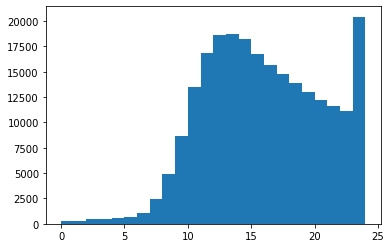

In [26]:
lengths = [len(x) for x in reviews_encoded]
plt.hist(lengths, bins=range(25))

In [27]:
print(reviews_encoded[135])

[256, 1686, 1915, 166, 394, 13, 645, 232, 4697, 9, 535, 2]


In [28]:
max_cap =8;
X = pad_sequences(reviews_encoded, maxlen=max_cap, truncating='post')

In [29]:
Y = np.array([[0,1] if '0' in label else [1,0] for label in labels])

In [30]:
np.random.seed(1024);
random_posits = np.arange(len(X))
np.random.shuffle(random_posits);

In [31]:
X = X[random_posits];
Y = Y[random_posits];

In [32]:
train_cap = int(0.85 * len(X));
dev_cap = int(0.93 * len(X));

In [33]:
X_train, Y_train = X[:train_cap], Y[:train_cap]
X_dev, Y_dev = X[train_cap:dev_cap], Y[train_cap:dev_cap]
X_test1, Y_test1 = X[dev_cap:], Y[dev_cap:]

In [127]:
from keras.models import Sequential
from keras.layers import Dense
from keras.backend import eval
from keras.optimizers import Adam
from keras.layers import LSTM
from keras.layers.embeddings import Embedding


model1 = Sequential();
model1.add(Embedding(len(word_dict)+1, max_cap, input_length=max_cap));
#adding a LSTM layer of dim 1--
model1.add(LSTM(150, return_sequences=True));
model1.add(LSTM(150, return_sequences=False));
#adding a dense layer with activation function of relu
model1.add(Dense(100, activation='relu', init='uniform'));#best 50,relu
#adding the final output activation with activation function of softmax
model1.add(Dense(2, activation='sigmoid', init='uniform'));
print(model1.summary());
optimizer = Adam(lr=0.0001, decay=0.0001);

model1.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
# fit model and run it for 5 epochs
model1.fit(X_train, Y_train, batch_size=16, epochs=5, validation_data=(X_dev, Y_dev))

Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.
D:\Anaconda3\envs\gputest\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(100, activation="relu", kernel_initializer="uniform")`
  from ipykernel import kernelapp as app
D:\Anaconda3\envs\gputest\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2, activation="sigmoid", kernel_initializer="uniform")`


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 8, 8)              1214248   
_________________________________________________________________
lstm_1 (LSTM)                (None, 8, 150)            95400     
_________________________________________________________________
lstm_2 (LSTM)                (None, 150)               180600    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               15100     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 202       
Total params: 1,505,550
Trainable params: 1,505,550
Non-trainable params: 0
_________________________________________________________________
None
Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.


Train on 464719 samples, validate on 43738 samples
Epoch 1/5
464719/464719 [==============================] - 604s 1ms/step - loss: 0.2613 - accuracy: 0.9092 - val_loss: 0.2511 - val_accuracy: 0.9101
Epoch 2/5
464719/464719 [==============================] - 530s 1ms/step - loss: 0.2405 - accuracy: 0.9129 - val_loss: 0.2474 - val_accuracy: 0.9108
Epoch 3/5
464719/464719 [==============================] - 529s 1ms/step - loss: 0.2369 - accuracy: 0.9138 - val_loss: 0.2471 - val_accuracy: 0.9110
Epoch 4/5
464719/464719 [==============================] - 531s 1ms/step - loss: 0.2355 - accuracy: 0.9143 - val_loss: 0.2472 - val_accuracy: 0.9112
Epoch 5/5
464719/464719 [==============================] - 537s 1ms/step - loss: 0.2346 - accuracy: 0.9145 - val_loss: 0.2467 - val_accuracy: 0.9112


In [128]:
filename = "model.pkl"
pickle.dump(model1,open(filename,'wb'))

In [129]:
filename = "model.sav"
pickle.dump(model1,open(filename,'wb'))

In [72]:
score = model1.evaluate(X_test1,Y_test1)
print("Test accuracy: %0.4f%%" % (score[1]*100))

38272/38272 [==============================] - 16s 420us/step
Test accuracy: 91.1776%


In [35]:
import pickle
model1 = pickle.load(open('lstm_model.pkl','rb'))

C:\Users\juyee\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [36]:
model1.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 8, 8)              1214248   
_________________________________________________________________
lstm_5 (LSTM)                (None, 300)               370800    
_________________________________________________________________
dense_7 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 202       
Total params: 1,615,350
Trainable params: 1,615,350
Non-trainable params: 0
_________________________________________________________________


In [37]:
Y_test1

array([[1, 0],
       [1, 0],
       [1, 0],
       ...,
       [1, 0],
       [1, 0],
       [1, 0]])

In [39]:
from sklearn.metrics import confusion_matrix, classification_report
predlstm = model1.predict(X_test1)
#predlstm
newpred = predlstm.round()
newpred
#predlstm1 = np.argmax(newpred,axis=1)
#testlstm = np.argmax(Y_test1,axis=1)
#print(confusion_matrix(Y_test1,predlstm))
#print('\n')
#print(classification_report(testlstm, predlstm1))

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [92]:
text = "As a long time coffee hater, I might be a good pick to review this kind of thing.  This is the second French coffee press I've gotten from the Vine.  The first was glass and it broke in the brewing process, maybe because I used boiling water instead of just hot, but I would have thought something that was meant to heat up like that would expand without breaking.  Strangely, a double walled glass tea cup with silicon brew cap also broke when adding boiling water, it was another Vine product. The good news here this is not glass, the bad news they failed at one of the most important parts.  That part is the press itself, specifically the seal!Before I return to that more about coffee hating.  I tried coffee as a kid and found it bitter and without substance.  I was even more confused when I found people drinking decaf, as the only benefit I saw from coffee was the caffeine.  How did I become a drinker, part experimentation and part education I guess.  When I was young, diners and donut shops dominated the Midwest, morning coffee was a big thing, but at that time no one knew from Starbucks or the Coffee Hut.  You drank coffee black, with milk or cream and maybe a bit of sugar, there were not the exotic creamers and flavorings of today.  My limited exposure to coffee was to brew a pot and put 3 ounces of milk six teaspoons of sugar in a cup and 5 ounces of coffee, mostly to get the caffeine.  I used it to stay up and study and though the taste was tolerable, it didn't make me crave it.The late 70s and early 1980s come along and those square cans of International Coffees hit the market and Mocha, and Vanilla coffee started a bit of a flavor revolution.  They were instants, but I liked them better and didn't have to go to the trouble of brewing.  The taste was more mellow and I realized what I didn't like about coffee was the bitter taste.  I worked in Houston at the time and although not quite New York, it was a fairly cosmopolitan city, especially compared to my home town in Indiana.  They had some coffee houses downtown, in quiet clubs that favored Jazz, chess, and activities. They also had really good coffee, some of them had an Italian contraption that could make Espresso, Cappuccino, and Lattes.  Did not know what those were, but I was educated by the maker and tried them.  Did not like Espresso, too strong for a non-coffee lover.  Cappuccino and Latte's are pretty much the same to me in taste, and I liked both, but where did the bitters go?It was explained to me by the professional staff of one of these coffee houses, (I've long forgotten the name), that bitterness is only a problem when the coffee is harshly boiled out of the grounds, and the ground is wrong, as it is for a lot of canned coffees.  The best, but mostly non-practical way to make great coffee if you have the right equipment, is to receive shipments of Arabica beans (usually the best although not that much more expensive than the alternative), then grind them daily with a radial grinder as needed, and keep the remainder refrigerated for not more than a week.  If you're a shop with good connections that might work, but few are.  I'd like to think the modern Starbucks gets beans fresh picked every week, but we all know they don't, and it's not like it degrades badly, it's just not in the realm of fantastic.  Since people mostly don't know what they are missing, having grown up with bad coffee anyway, a little better seems really nice.  Why else would you fork over 4 dollars for what you paid 10 cents for in the Late 70's and with free refills to boot!Back to the product here, the French press.  I guess the theory is instead of pouring water over the grounds, we let them brew in the water and then press the coffee though the filter sort of in reverse.  The instructions say use a coarse ground, and that's definitely true because you make the problem I had worse.  I might have been OK if I'd let everything settle and kept this on the table, but I picked it up before I used the plunger.  I got grounds in my first cut which are nasty to drink.  I examined the plunger and the seal.  The seal has a fine mesh, and an outer spring to push with some tension.  Unfortunately the mesh was bent in a few places and I could see gaps on the side walls of the pot.  The gaps were big enough to let grounds through.  The producer of this failed at the most critical part.  Still, I wanted to see the taste so I poured the coffee through a fine mesh strainer and added creamers and sugar.  It was very good coffee, much better than the BUN machine at work makes even when it's fresh, it's too bad I have to double filter it. They either need a better sealing mechanism or stricter quality control on the mesh.  At least it worked and didn't break like the glass one.Bottom Line a no recommend, decent coffee, but does not always work as advertised.  Maybe the reviews on the Zon will reveal a model that creates a better seal, but if I'd paid money for this, I would have sent it back.  I'm still going to use the mini brewer that I paid two dollars at a yard sale for.  It works and the coffee is not bad.  You'd think as long as they've been making French presses, they'd have them perfected by now!"
review_clean = clean_document(text)
sentence = [' '.join(review_clean)]
print(sentence)

['long time coffee hater might good pick review kind thing second french coffee press gotten vine first glass broke brewing process maybe used boiling water instead hot would thought something meant heat like would expand without breaking strangely double walled glass tea cup silicon brew cap also broke adding boiling water another vine product good news glass bad news failed one important parts part press specifically seal return coffee hating tried coffee kid found bitter without substance even confused found people drinking decaf benefit saw coffee caffeine become drinker part experimentation part education guess young diners donut shops dominated midwest morning coffee big thing time one knew starbucks coffee hut drank coffee black milk cream maybe bit sugar exotic creamers flavorings today limited exposure coffee brew pot put ounces milk six teaspoons sugar cup ounces coffee mostly get caffeine used stay study though taste tolerable make crave late 70s early 1980s come along squar

In [80]:
tokenizer.fit_on_texts(sentence)
text_sequence = np.array(tokenizer.texts_to_sequences(sentence))

In [81]:
print(text_sequence)

[[  241   155   195  4062   779  1579   777   534  1296    34    95  3584
      7   555   598  2755    12   961 16693  4296  2184   264    65   465
    492   961    51  8045   190  4688     3 10839  6159   124   138 19134
   9034   138   356  1597  3728   143  6176  4062  6287     5    62   162
   6202   607   493  2948    53 10388   961]]


In [93]:
review_encoded = [];

review_encoded.append([sequence_dict[x] for x in review_clean]);

In [94]:
review_encoded

[[58,
  10,
  14,
  23455,
  196,
  7,
  576,
  187,
  339,
  56,
  245,
  543,
  14,
  199,
  964,
  2847,
  33,
  123,
  486,
  830,
  657,
  292,
  15,
  831,
  18,
  255,
  57,
  6,
  152,
  93,
  1429,
  115,
  3,
  6,
  3025,
  65,
  1288,
  8851,
  667,
  3263,
  123,
  142,
  52,
  2261,
  550,
  1082,
  13,
  486,
  1106,
  831,
  18,
  70,
  2847,
  24,
  7,
  3173,
  123,
  260,
  3173,
  1643,
  1,
  749,
  408,
  218,
  199,
  2004,
  475,
  516,
  14,
  13034,
  160,
  14,
  2053,
  109,
  2673,
  65,
  4986,
  25,
  4019,
  109,
  189,
  991,
  4468,
  2188,
  536,
  14,
  5503,
  924,
  2307,
  218,
  6328,
  218,
  12236,
  488,
  2393,
  15143,
  5326,
  4883,
  22589,
  11351,
  464,
  14,
  83,
  56,
  10,
  1,
  957,
  2156,
  14,
  21654,
  5142,
  14,
  306,
  412,
  399,
  292,
  60,
  748,
  8173,
  12793,
  8231,
  750,
  1130,
  6054,
  14,
  550,
  103,
  30,
  1119,
  412,
  923,
  4983,
  748,
  52,
  1119,
  14,
  854,
  8,
  5503,
  15,
  416,
  4311,
  

In [95]:
max_cap =8;
test_data = pad_sequences(review_encoded, maxlen=max_cap, truncating='post')

In [96]:
test_data

array([[   58,    10,    14, 23455,   196,     7,   576,   187]])

In [97]:
np.random.seed(1024);
random_posit = np.arange(len(test_data))
np.random.shuffle(random_posit);

In [98]:
test_data = test_data[random_posit];

In [99]:
test_result = model1.predict(test_data)
print(test_result)

[[0.77683055 0.22285935]]


In [89]:
test_result = test_result.round()
test_result1 = np.argmax(test_result,axis=1)

In [90]:
print(test_result)

[[1. 0.]]
